In [16]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


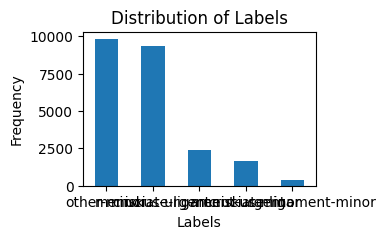

In [17]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [18]:
epochs = 6
model_name = "lr_finder"

In [19]:
from utils import get_standard_parameters

optimizer, loss, metrics, earlystopping_callback, embedding_dim, lstm_units, _, batch_size = get_standard_parameters()

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import numpy as np
import keras.backend as K

class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-5, max_lr=1, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.lr_increment = (max_lr - min_lr) / self.total_iterations
        self.iteration = 0
        self.lrs = []
        self.losses = []

    def on_batch_begin(self, batch, logs=None):
        lr = self.min_lr + self.iteration * self.lr_increment
        self.model.optimizer.learning_rate.assign(lr)
        self.lrs.append(lr)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.iteration += 1
        self.losses.append(logs.get('loss'))
        if self.iteration > 5 and logs.get('loss') > 4 * min(self.losses):
            self.model.stop_training = True

    def get_best_lr(self):
        if self.losses:
            min_loss_idx = np.argmin(self.losses)  # Get the index of the minimum loss
            return self.lrs[min_loss_idx]  # Return the corresponding learning rate
        else:
            return None  # Return None if no losses were recorded


    def plot_lr(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

# Usage:
lr_finder = LearningRateFinder(min_lr=1e-5, max_lr=10, steps_per_epoch=np.ceil(len(train_padded)/32), epochs=3)


# Model definition and training

In [21]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [22]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[lr_finder])

Epoch 1/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 104s 139ms/step - accuracy: 0.2508 - auc: 0.6063 - f1_score: 0.1508 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 2/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 107s 146ms/step - accuracy: 0.0156 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 3/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 117s 159ms/step - accuracy: 0.0147 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 4/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 122s 166ms/step - accuracy: 0.0155 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 5/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 123s 168ms/step - accuracy: 0.0134 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_sco

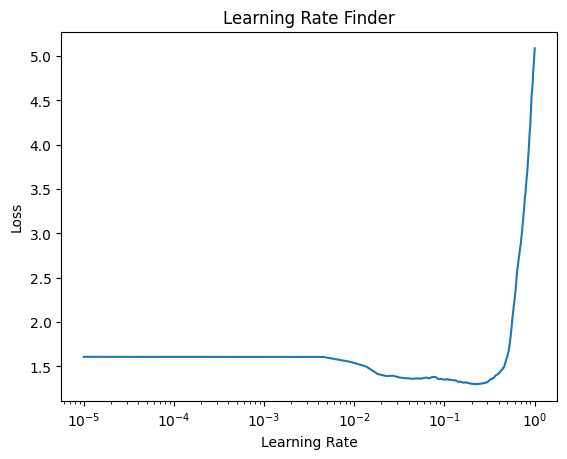

In [23]:
lr_finder.plot_lr()

In [24]:
lr = lr_finder.get_best_lr()
print(lr)

1.009972758152174


In [25]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)

In [26]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[earlystopping_callback])

Epoch 1/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 108s 144ms/step - accuracy: 0.0524 - auc: 0.5080 - f1_score: 0.0418 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 2/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 118s 160ms/step - accuracy: 0.0140 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 3/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 123s 167ms/step - accuracy: 0.0161 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 4/6
736/736 ━━━━━━━━━━━━━━━━━━━━ 126s 171ms/step - accuracy: 0.0160 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [27]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/lr_finder/lr_finder.h5
Data saved


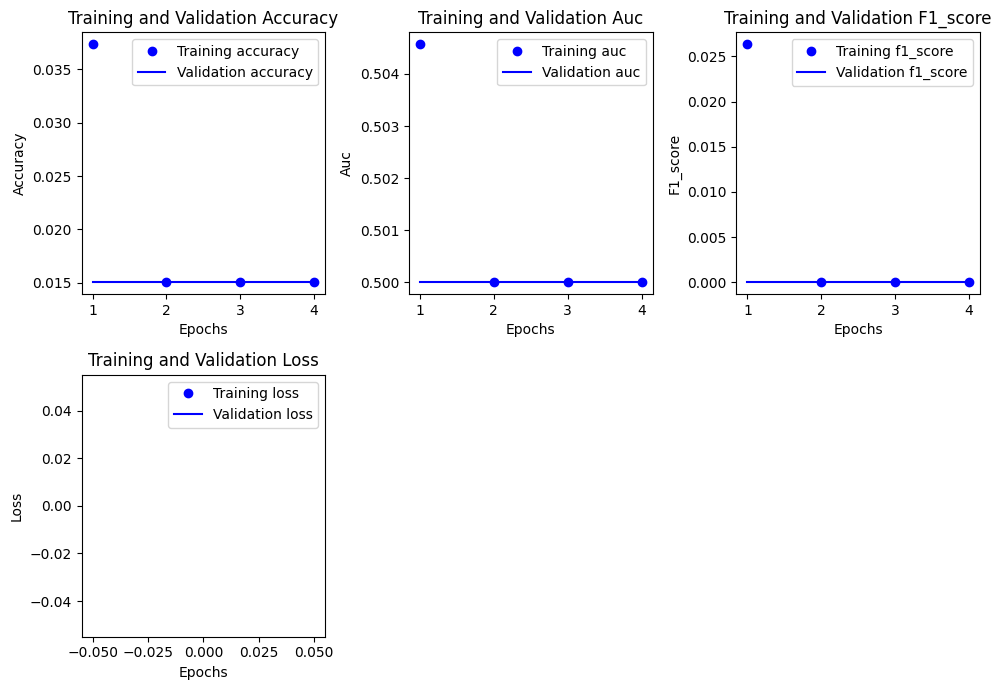

In [28]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step


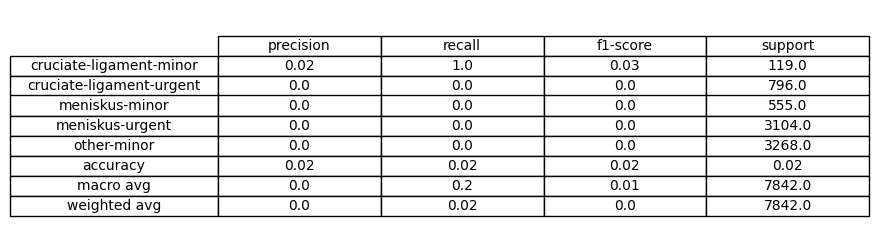

In [29]:
eval(model, test_padded, test_labels, label_encoder)